In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
import collections
import pathlib
import re
import string
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import matplotlib.pyplot as plt
import tensorflow_text as tf_text
from tensorflow import keras

In [2]:
tfds.disable_progress_bar()

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
#batch_size = 32
seed = 42

train_dataset = preprocessing.text_dataset_from_directory(
    'bbcsport',
#    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 737 files belonging to 5 classes.
Using 590 files for training.


In [4]:
test_dataset = preprocessing.text_dataset_from_directory(
    'bbcsport',
#    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    seed=seed)

Found 737 files belonging to 5 classes.
Using 147 files for validation.


In [5]:
VOCAB_SIZE=5000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [6]:
model = tf.keras.Sequential([
    encoder,  
    tf.keras.layers.Embedding( 
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [7]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [8]:
earlystopping_cb = keras.callbacks.EarlyStopping (patience=10, restore_best_weights=True)

In [9]:
history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset, 
                    validation_steps=5,
                    callbacks=earlystopping_cb)

Epoch 1/50
19/19 [==============================] - 14s 753ms/step - loss: 1.5593 - accuracy: 0.3441 - val_loss: 1.6051 - val_accuracy: 0.3401
Epoch 2/50
19/19 [==============================] - 12s 609ms/step - loss: 1.4524 - accuracy: 0.3746 - val_loss: 1.3732 - val_accuracy: 0.3741
Epoch 3/50
19/19 [==============================] - 11s 599ms/step - loss: 1.0973 - accuracy: 0.5068 - val_loss: 1.6630 - val_accuracy: 0.4490
Epoch 4/50
19/19 [==============================] - 11s 573ms/step - loss: 0.9727 - accuracy: 0.5949 - val_loss: 0.9535 - val_accuracy: 0.5918
Epoch 5/50
19/19 [==============================] - 12s 622ms/step - loss: 0.6060 - accuracy: 0.7847 - val_loss: 0.6960 - val_accuracy: 0.6667
Epoch 6/50
19/19 [==============================] - 11s 569ms/step - loss: 0.2811 - accuracy: 0.9288 - val_loss: 0.4664 - val_accuracy: 0.8503
Epoch 7/50
19/19 [==============================] - 11s 599ms/step - loss: 0.1548 - accuracy: 0.9508 - val_loss: 0.3652 - val_accuracy: 0.8844

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

5/5 [==============================] - 1s 111ms/step - loss: 0.2824 - accuracy: 0.9184
Test Loss: 0.28239113092422485
Test Accuracy: 0.918367326259613


(0.0, 1.7460851625713985)

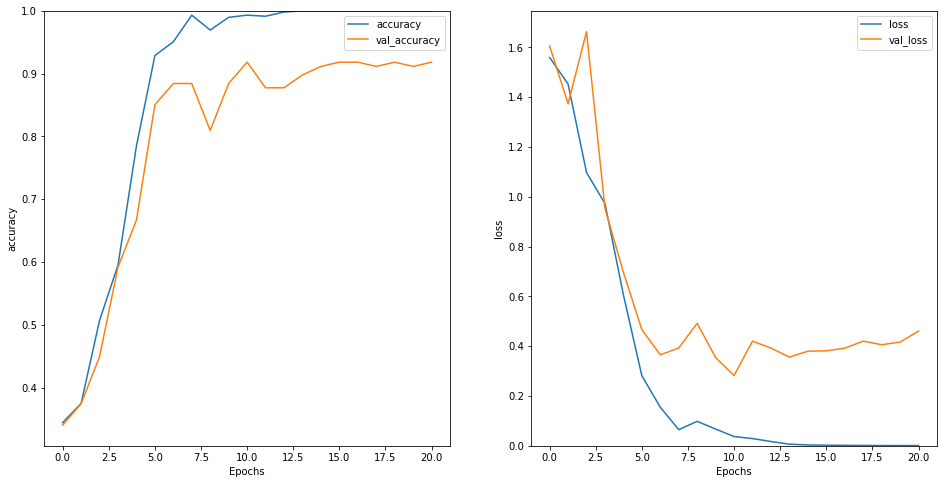

In [11]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)